In [3]:
from keras.applications import Xception
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

base_model = Xception(False, "imagenet")
for layer in base_model.layers:
    layer.trainable = True
    
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(base_model.input, predictions)

In [4]:
from Datasets import Datasets

dataset_name = "Bradbury"
dataset = Datasets.datasets()[dataset_name]

In [5]:
from keras.applications.xception import preprocess_input
import numpy as np

# Add preprocessing
train_images = dataset[0].images
train_labels  = dataset[0].labels

test_images = dataset[1].images
test_labels = dataset[1].labels

validation_images = dataset[2].images
validation_labels = dataset[2].labels


In [50]:
validation_images.shape, validation_labels.shape

((1022, 75, 75, 3), (1022,))

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from ProjectPaths import ProjectPaths

In [99]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator()


In [100]:
from PerformanceMetrics import PerformanceMetrics
from keras.optimizers import SGD

model.compile(optimizer="rmsprop", loss='binary_crossentropy',
                  metrics=['accuracy', PerformanceMetrics.precision,
                           PerformanceMetrics.recall, PerformanceMetrics.fmeasure])

In [101]:
batch_size = 64

train_generator = data_generator.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size, shuffle=False)

In [102]:

from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping


epochs = 100

model_name = "xception_idg_wr_{}".format(dataset_name)

checkpoint_dir = ProjectPaths.checkpoint_dir_for(model_name, batch_size, epochs)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

file_in_checkpoint_dir = ProjectPaths.file_in_checkpoint_dir(model_name, batch_size,
                                                                 epochs,  model_name +
                                                                 "__{epoch:02d}_{val_acc:.2f}.hdf5")

early_stopping_callback = EarlyStopping(patience=10)
model_checkpoint_callback = ModelCheckpoint(file_in_checkpoint_dir, monitor='val_acc', verbose=True,
                                                save_weights_only=True,
                                                save_best_only=True)

log_dir = os.path.join(ProjectPaths.log_dir(), model_name)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0,  write_graph=False, write_images=False)


model.fit_generator(train_generator,
                    steps_per_epoch=len(train_labels) // batch_size, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback],
                    validation_data=test_generator,
                    validation_steps=len(test_labels))



Epoch 1/100
56/56 [==============================] - 10s 172ms/step - loss: 0.0608 - acc: 0.9824 - precision: 0.9860 - recall: 0.9793 - fmeasure: 0.9824 - val_loss: 0.0590 - val_acc: 0.9853 - val_precision: 0.9755 - val_recall: 0.9956 - val_fmeasure: 0.9852

Epoch 00001: val_acc improved from -inf to 0.98532, saving model to /media/tim/Data/Work/CBS/Code_hannah/Models/xception_idg_wr_Bradbury_2018-08-31_64_100/xception_idg_wr_Bradbury__01_0.99.hdf5
Epoch 2/100
56/56 [==============================] - 6s 114ms/step - loss: 0.0523 - acc: 0.9827 - precision: 0.9851 - recall: 0.9802 - fmeasure: 0.9822 - val_loss: 0.0501 - val_acc: 0.9912 - val_precision: 0.9845 - val_recall: 0.9978 - val_fmeasure: 0.9910

Epoch 00002: val_acc improved from 0.98532 to 0.99119, saving model to /media/tim/Data/Work/CBS/Code_hannah/Models/xception_idg_wr_Bradbury_2018-08-31_64_100/xception_idg_wr_Bradbury__02_0.99.hdf5
Epoch 3/100
56/56 [==============================] - 6s 114ms/step - loss: 0.0374 - acc: 0.9

In [11]:
#model.load_weights(r"/media/tim/Data/Work/CBS/Code_hannah/Models/xception_idg_Bradbury_2018-08-31_64_100/xception_idg_Bradbury__25_0.98.hdf5")


In [103]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

def find_optimal_cutoff(target, predicted):
   """ Find the optimal probability cutoff point for a classification model related to event rate
   Parameters
   ----------
   target : Matrix with dependent or target data, where rows are observations

   predicted : Matrix with predicted data, where rows are observations

   Returns
   -------
   list type, with optimal cutoff value

   """
   fpr, tpr, threshold = roc_curve(target, predicted)
   i = np.arange(len(tpr))
   roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
   roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

   return list(roc_t['threshold'])

# Evaluation of Bradbury

In [104]:
train_eval = model.evaluate(train_images, train_labels, batch_size)
test_eval = model.evaluate(test_images, test_labels, batch_size)
validation_eval = model.evaluate(validation_images, validation_labels, batch_size)

np_model_evaluations = np.array([train_eval, test_eval, validation_eval])

evaluations = pd.DataFrame(np_model_evaluations, columns=model.metrics_names)
print(evaluations.head())

1022/1022 [==============================] - 0s 419us/step
       loss       acc  precision    recall  fmeasure
0  0.208522  0.984915   0.997591  0.971986  0.984327
1  0.207153  0.978474   0.984954  0.972724  0.978567
2  0.170743  0.979452   0.975884  0.984309  0.979732


In [105]:
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_images, batch_size)

In [15]:
curve = roc_curve(test_labels, test_predictions)
curve

(array([  0.00000000e+00,   4.96277916e-04,   4.96277916e-04,
          4.96277916e-04,   4.96277916e-04,   9.92555831e-04,
          9.92555831e-04,   9.92555831e-04,   9.92555831e-04,
          9.92555831e-04,   9.92555831e-04,   9.92555831e-04,
          1.48883375e-03,   1.48883375e-03,   1.48883375e-03,
          1.48883375e-03,   1.48883375e-03,   1.48883375e-03,
          1.48883375e-03,   1.48883375e-03,   1.48883375e-03,
          1.48883375e-03,   1.48883375e-03,   1.48883375e-03,
          1.98511166e-03,   1.98511166e-03,   1.98511166e-03,
          1.98511166e-03,   1.98511166e-03,   1.98511166e-03,
          1.98511166e-03,   1.98511166e-03,   1.98511166e-03,
          1.98511166e-03,   1.98511166e-03,   1.98511166e-03,
          1.98511166e-03,   1.98511166e-03,   1.98511166e-03,
          1.98511166e-03,   1.98511166e-03,   1.98511166e-03,
          1.98511166e-03,   1.98511166e-03,   1.98511166e-03,
          1.98511166e-03,   1.98511166e-03,   1.98511166e-03,
        

In [106]:
# Find this nicely later
cut_off = find_optimal_cutoff(test_labels, test_predictions)
cut_off

/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0.36068668961524963]

In [107]:
predicted_labels = test_predictions > cut_off
confusion_matrix(test_labels, predicted_labels)


array([[507,  11],
       [ 13, 491]])

In [108]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

             precision    recall  f1-score   support

          0       0.97      0.98      0.98       518
          1       0.98      0.97      0.98       504

avg / total       0.98      0.98      0.98      1022



# Evaluation of Aachen

Evaluation of the Aachen dataset with the model trained on Bradbury California

In [109]:
ac_dataset = Datasets.datasets()["AcMüDüHo"]

train_images = ac_dataset[0].images
train_labels = ac_dataset[0].labels

test_images = ac_dataset[1].images
test_labels = ac_dataset[1].labels

validation_images = ac_dataset[2].images
validation_labels = ac_dataset[2].labels

eval_images = np.concatenate((train_images, test_images, validation_images), axis=0)
eval_labels = np.concatenate((train_labels, test_labels, validation_labels), axis=0)


print(train_images.shape, test_images.shape, validation_images.shape)
print(eval_images.shape, eval_labels.shape)

(3357, 75, 75, 3) (374, 75, 75, 3) (934, 75, 75, 3)
(4665, 75, 75, 3) (4665,)


In [110]:
eval_predictions = model.predict(eval_images, batch_size) > cut_off
confusion_matrix(eval_labels, eval_predictions)

array([[1736,  598],
       [1521,  810]])

In [111]:
from sklearn.metrics import classification_report

print(classification_report(eval_labels, eval_predictions))

             precision    recall  f1-score   support

        0.0       0.53      0.74      0.62      2334
        1.0       0.58      0.35      0.43      2331

avg / total       0.55      0.55      0.53      4665



# Evaluation of Fresno

In [112]:
fresno_dataset = Datasets.datasets()["Fresno"]

train_images = fresno_dataset[0].images
train_labels = fresno_dataset[0].labels

test_images = fresno_dataset[1].images
test_labels = fresno_dataset[1].labels

validation_images = fresno_dataset[2].images
validation_labels = fresno_dataset[2].labels

fresno_eval_images = np.concatenate((train_images, test_images, validation_images), axis=0)
fresno_eval_labels = np.concatenate((train_labels, test_labels, validation_labels), axis=0)


print(train_images.shape, test_images.shape, validation_images.shape)
print(fresno_eval_images.shape, fresno_eval_labels.shape)

(3646, 75, 75, 3) (1022, 75, 75, 3) (1022, 75, 75, 3)
(5690, 75, 75, 3) (5690,)


In [113]:
fresno_eval_predictions = model.predict(fresno_eval_images, batch_size) > cut_off
confusion_matrix(fresno_eval_labels, fresno_eval_predictions)

array([[2810,   35],
       [  70, 2775]])

In [114]:
from sklearn.metrics import classification_report

print(classification_report(fresno_eval_labels, fresno_eval_predictions))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      2845
          1       0.99      0.98      0.98      2845

avg / total       0.98      0.98      0.98      5690



# Evaluation DeepSolaris set by Stefano

In [115]:

neg_path = os.path.join(ProjectPaths.image_dir(), "neg")
pos_path = os.path.join(ProjectPaths.image_dir(), "pos")

neg_images = [os.path.join(neg_path, image_path) for image_path in os.listdir(neg_path) if file.endswith('png') or file.endswith('jpg')]
pos_images = [os.path.join(pos_path, image_path) for image_path in os.listdir(pos_path) if file.endswith('png') or file.endswith('jpg')]
len(neg_images), len(pos_images)

(15966, 2536)

In [86]:
from keras.preprocessing.image import load_img

def plot_images(image_paths):
    _, ax = plt.subplots(5,5, figsize=(15,15))

    i = 0
    for r in range(5):
        for c in range(5):
            ax[r, c].imshow(load_img(image_paths[i]))
            i += 1
            



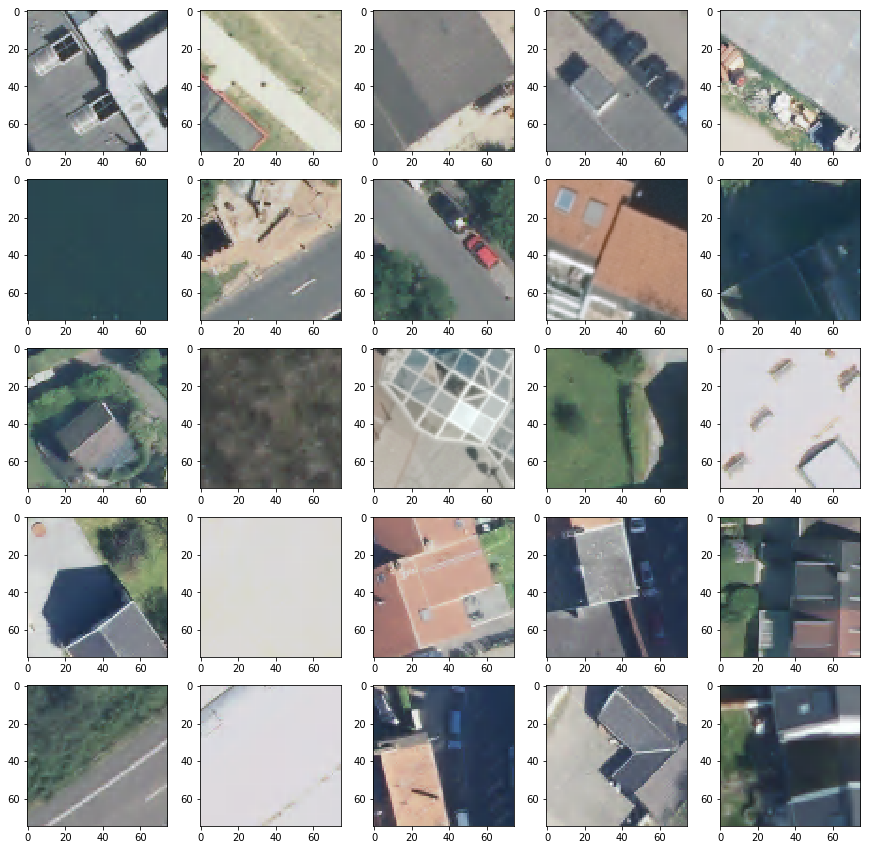

In [28]:
plot_images(neg_images)

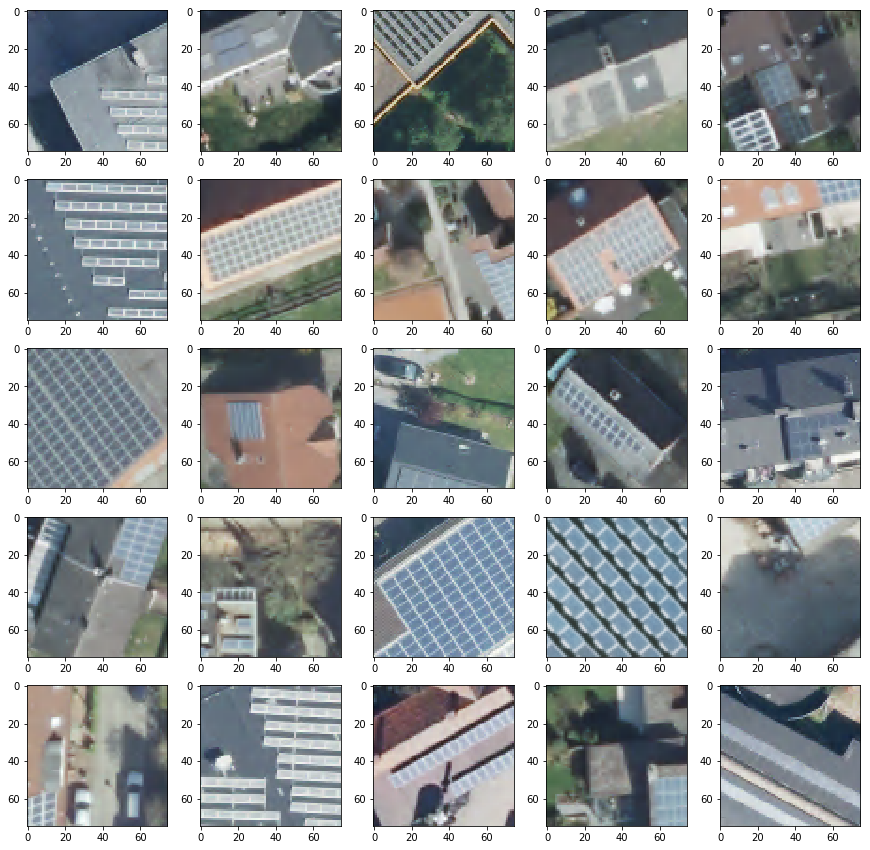

In [29]:
plot_images(pos_images)

In [116]:
all_images = neg_images + pos_images

deepsolaris_image_labels = [0 for _ in range(len(neg_images))] + [1 for _ in range(len(pos_images))]
len(deepsolaris_image_labels), len(all_images)

(18502, 18502)

In [117]:
from skimage.transform import resize

deepsolaris_images = np.array([resize(img_to_array(load_img(path)) / 255., (75,75,3)) for path in all_images])

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [98]:
deepsolaris_images.shape, deepsolaris_images.min(), deepsolaris_images.max()

((18502, 75, 75, 3), 0.0, 1.0)

In [118]:
deepsolaris_predictions = model.predict(deepsolaris_images, batch_size) > cut_off
confusion_matrix(deepsolaris_image_labels, deepsolaris_predictions)

array([[9554, 6412],
       [1528, 1008]])

In [119]:
from sklearn.metrics import classification_report

print(classification_report(deepsolaris_image_labels, deepsolaris_predictions))

             precision    recall  f1-score   support

          0       0.86      0.60      0.71     15966
          1       0.14      0.40      0.20      2536

avg / total       0.76      0.57      0.64     18502

